# Signatures

Comparison of the ALP decay lengths predicted by several benchmark models and the expected experimental signatures (prompt, displaced vertex or invisible decay).

In [ ]:
import alpaca
import numpy as np
from alpaca.constants import mB, mK, hbarc_GeVnm
import matplotlib.pyplot as plt
from alpaca.common import kallen
from scipy.integrate import quad_vec
plt.rcParams.update({'font.size': 12, 'text.usetex': True, 'font.family': 'serif', 'font.serif': 'Computer Modern Roman'})

In [2]:
ma = np.logspace(-2, 1, 200)
ctau_exp = np.logspace(-9, 8, 100)

x_ma, y_ctau = np.meshgrid(ma, ctau_exp)



In [3]:
c_DFSZ = alpaca.uvmodels.QED_DFSZ.get_couplings({alpaca.uvmodels.beta: np.pi/4}, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)
c_uDFSZ = alpaca.uvmodels.u_DFSZ.get_couplings({alpaca.uvmodels.beta: np.pi/4}, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)
c_eDFSZ = alpaca.uvmodels.e_DFSZ.get_couplings({alpaca.uvmodels.beta: np.pi/4}, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)
c_qKSVZ = alpaca.uvmodels.Q_KSVZ.get_couplings({alpaca.uvmodels.KSVZ_charge: 1}, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)
c_yKSVZ = alpaca.uvmodels.Y_KSVZ.get_couplings({alpaca.uvmodels.KSVZ_charge: 1}, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)
c_lKSVZ = alpaca.uvmodels.L_KSVZ.get_couplings({alpaca.uvmodels.KSVZ_charge: 1}, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)
c_top = alpaca.ALPcouplings({'cuR': np.diag([0,0,1])}, 40000*np.pi, 'derivative_above').match_run(10.01, 'VA_below', match_tildecouplings=True)
c_flaxion = alpaca.uvmodels.flaxion_benchmark.get_couplings(0.2, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)
c_nonunivDFSZ = alpaca.uvmodels.nonuniversal_DFSZ.get_couplings({alpaca.uvmodels.beta: np.arctan(10.0)}, 40000*np.pi).match_run(10.01, 'VA_below', match_tildecouplings=True)

In [4]:
dws_DFSZ = alpaca.decay_width('a', ma, c_DFSZ, 10000, integrator='no_rge')
dws_uDFSZ = alpaca.decay_width('a', ma, c_uDFSZ, 10000, integrator='no_rge')
dws_eDFSZ = alpaca.decay_width('a', ma, c_eDFSZ, 10000, integrator='no_rge')
dws_qKSVZ = alpaca.decay_width('a', ma, c_qKSVZ, 10000, integrator='no_rge')
dws_yKSVZ = alpaca.decay_width('a', ma, c_yKSVZ, 10000, integrator='no_rge')
dws_lKSVZ = alpaca.decay_width('a', ma, c_lKSVZ, 10000, integrator='no_rge')
dws_top = alpaca.decay_width('a', ma, c_top, 10000, integrator='no_rge')
dws_flaxion = alpaca.decay_width('a', ma, c_flaxion, 10000, integrator='no_rge')
dws_nonunivDFSZ = alpaca.decay_width('a', ma, c_nonunivDFSZ, 10000, integrator='no_rge')

In [5]:
ctau_DFSZ = hbarc_GeVnm/np.array(dws_DFSZ)/1e9
ctau_uDFSZ = hbarc_GeVnm/np.array(dws_uDFSZ)/1e9
ctau_eDFSZ = hbarc_GeVnm/np.array(dws_eDFSZ)/1e9
ctau_qKSVZ = hbarc_GeVnm/np.array(dws_qKSVZ)/1e9
ctau_yKSVZ = hbarc_GeVnm/np.array(dws_yKSVZ)/1e9
ctau_lKSVZ = hbarc_GeVnm/np.array(dws_lKSVZ)/1e9
ctau_top = hbarc_GeVnm/np.array(dws_top)/1e9
ctau_flaxion = hbarc_GeVnm/np.array(dws_flaxion)/1e9
ctau_nonunivDFSZ = hbarc_GeVnm/np.array(dws_nonunivDFSZ)/1e9

In [6]:
def decay_probability_BelleII(decay_type: str, ctau: float | None = None, ma: float | None = None, theta: float | None = None, br_dark = 0) -> float:
    rmin = 0.1
    rmax = 100
    lab_boost = 0.28
    mass_parent = mB
    mass_sibling = mK
    if decay_type == 'flat':
        return 1
    kallen_M = kallen(mass_parent**2, ma**2, mass_sibling**2)
    kallen_M = np.where(kallen_M >0, kallen_M, np.nan)
    pa_parent = np.sqrt(kallen_M)/(2*mass_parent)
    if lab_boost == 0:
        pa_lab = pa_parent
    else:
        Ea_parent = (mass_parent**2 + ma**2 - mass_sibling**2)/(2*mass_parent)
        lab_gamma = np.sqrt(1 + lab_boost**2)
        pa = lambda th: np.sqrt((lab_boost * Ea_parent + lab_gamma * pa_parent * np.cos(th))**2 + (pa_parent * np.sin(th))**2)
        if theta is None:
            pa_lab = quad_vec(pa, 0, np.pi)[0]/np.pi
        else:
            pa_lab = pa(theta)
    betagamma = pa_lab/ma
    underflow_error = np.geterr()['under']
    np.seterr(under='ignore')
    if decay_type == 'prompt':
        result = 1 - np.exp(-rmin/ctau/betagamma)
    elif decay_type == 'displaced':
        result = np.exp(-rmin/ctau/betagamma) - np.exp(-rmax/ctau/betagamma)
    elif decay_type == 'invisible':
        br_dark = np.atleast_1d(br_dark)
        prob = np.exp(-rmax/ctau/betagamma)
        result = prob + (1 - prob)*br_dark
    np.seterr(under=underflow_error)
    return result

In [7]:
probs = np.stack([decay_probability_BelleII('prompt', y_ctau*100, x_ma), decay_probability_BelleII('displaced', y_ctau*100, x_ma), decay_probability_BelleII('invisible', y_ctau*100, x_ma)], axis=-1)

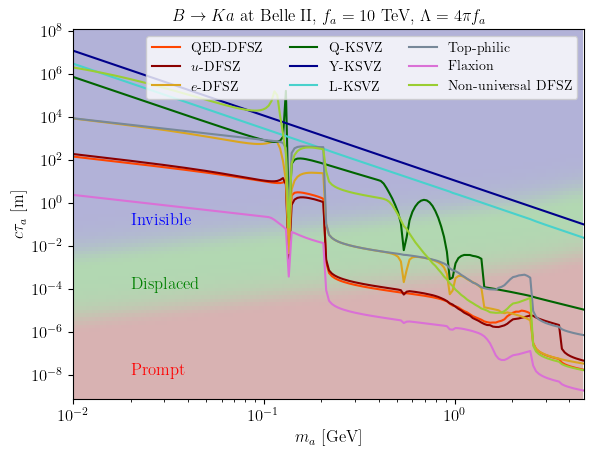

In [ ]:
plt.figure(figsize=(15.5/2.54, 12/2.54))

plt.pcolormesh(x_ma, y_ctau, probs/2, alpha=0.3, zorder=-20)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

plt.loglog(ma, ctau_DFSZ, label='QED-DFSZ', c='orangered', lw=1.5)
plt.loglog(ma, ctau_uDFSZ, label='$u$-DFSZ', c='darkred', lw=1.5)
plt.loglog(ma, ctau_eDFSZ, label='$e$-DFSZ', c='goldenrod', lw=1.5)
plt.loglog(ma, ctau_qKSVZ, label='Q-KSVZ', c='darkgreen', lw=1.5)
plt.loglog(ma, ctau_yKSVZ, label='Y-KSVZ', c='darkblue', lw=1.5)
plt.loglog(ma, ctau_lKSVZ, label='L-KSVZ', c='mediumturquoise', lw=1.5)
plt.loglog(ma, ctau_top, label='Top-philic', c='lightslategray', lw=1.5)
plt.loglog(ma, ctau_flaxion, label='Flaxion', c='orchid', lw=1.5)
plt.loglog(ma, ctau_nonunivDFSZ, label='Non-universal DFSZ', c='yellowgreen', lw=1.5)

plt.text(2e-2, 1e-8, 'Prompt', color='r')
plt.text(2e-2, 1e-4, 'Displaced', color='g')
plt.text(2e-2, 1e-1, 'Invisible', color='b')

plt.xlim(1e-2, mB-mK)

plt.legend(fontsize=10, ncols=3, loc='upper right')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$c\tau_a$ [m]')
plt.title(r'$B\to K a$ at Belle II, $f_a = 10$ TeV, $\Lambda=4\pi f_a$', fontsize=12)
ax.set_rasterization_zorder(-10)
plt.tight_layout()
#plt.savefig('ctau_BK.pdf', dpi=500)